# Data Science Group Project Report 006-021
## Heart Disease Hungarian Data:
##### Members: 
- Jaden Lai (79465795)
- Percy Pham (70210562)
- Sydney Trim (86059649)

#### Introduction:
Heart disease is a leading cause of death worldwide associated with many variables. This project aims to identify patients most likely to experience heart problems by analyzing age, resting blood pressure, maximum heart rate, and cholestrol. To answer this question we will be analyzing the Heart Disease Data Set from the Hungarian Institute of Cardiology. This dataset provides fourteen attributes. However, we have selected five of them to find an answer to our question.

#### Question: 
What kind of patients are most likely to experience heart disease using age, resting blood pressure, maximum heart rate, and cholestrol?

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Methods & Results

We begin by downloading, cleaning, and wrangling the data set where we assign column names, select our variables of interest, and filter missing cells; all the pre-processing needed to analyze this heart data set.

In [28]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", "project.csv")
heart_disease_hungarian <- read_csv("project.csv", col_names = FALSE)
colnames(heart_disease_hungarian) <- c("age", "sex", "chest_pain", "resting_blood_pressure", "cholesterol",
                                       "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", 
                                       "exercise_induced_angina", "ST_depression",
                                       "slope_of_peak_exercise_ST_segment",
                                       "number_of_major_vessels", "thalassemia", "heart_disease_cases")

heart_disease_hungarian <- heart_disease_hungarian |>
             select(age, resting_blood_pressure, maximum_heart_rate_achieved,  cholesterol, heart_disease_cases) |>
             mutate(maximum_heart_rate_achieved = as.numeric(maximum_heart_rate_achieved)) |>
             mutate(cholesterol = as.numeric(cholesterol)) |>
             mutate(resting_blood_pressure = as.numeric(resting_blood_pressure)) |>
             mutate(heart_disease_cases = as.factor(heart_disease_cases)) |>
             filter(maximum_heart_rate_achieved != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(age != "NA") |>
             filter(resting_blood_pressure != "NA") |>
             filter(cholesterol != "?")

heart_disease_hungarian

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,resting_blood_pressure,maximum_heart_rate_achieved,cholesterol,heart_disease_cases
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,185,132,0
29,120,160,243,0
30,170,170,237,0
⋮,⋮,⋮,⋮,⋮
56,155,150,342,1
58,180,110,393,1
65,130,115,275,1


##### Variable Explanation:
- Resting blood pressure: mmHg
- Cholesterol: mg/dl
- Heat disease cases: 1 = Positive, 0 = Negative

Now that we have cleaned our dataset, we perform a summary in preparation for exploratory data analysis.

In [29]:
 heart_disease_hungarian_summarize <- heart_disease_hungarian |> 
            filter(heart_disease_cases == 1) |>
            group_by(age) |>
            summarize(case_count = n()) |>
            arrange(case_count)

heart_disease_hungarian_summarize
tail(heart_disease_hungarian_summarize, 7)

age,case_count
<dbl>,<int>
31,1
32,1
33,1
⋮,⋮
48,8
52,8
54,8


age,case_count
<dbl>,<int>
56,5
58,5
46,6
⋮,⋮
48,8
52,8
54,8


##### Table Summary:
Organizing our data set, we can make an inference that heart disease cases are mostly found in older patients in the age range of 45-55,testing positive most frequently at the age of 54, and as early as 31.

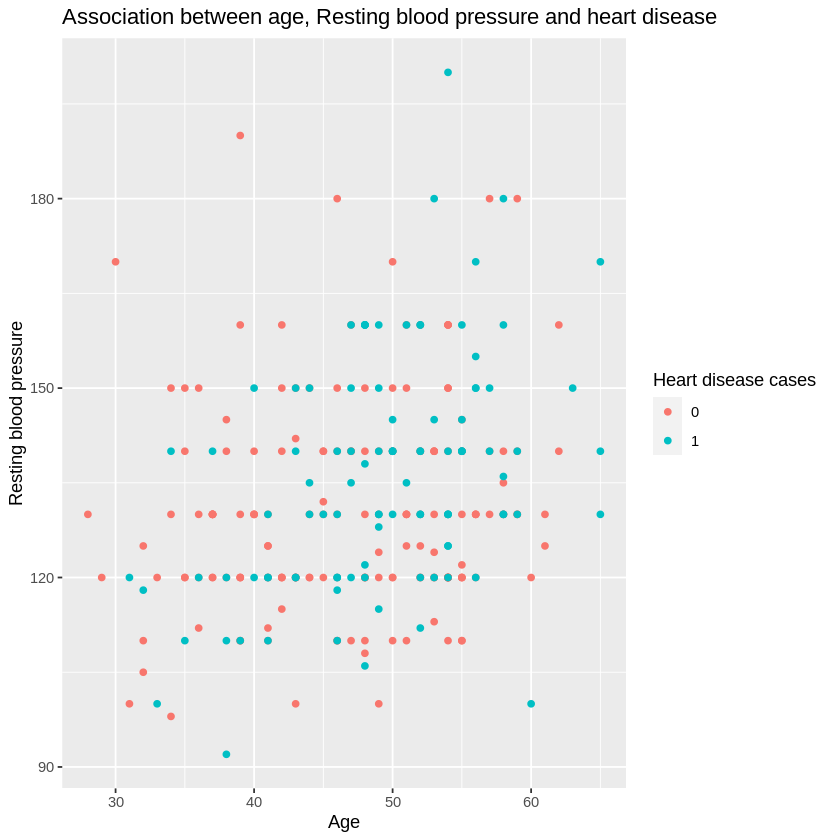

In [30]:
heart_disease_plot <- heart_disease_hungarian |> 
    ggplot(aes(x = age, y = resting_blood_pressure, color = heart_disease_cases)) + 
        geom_point() +
        labs(x = "Age", y = "Resting blood pressure", color = "Heart disease cases", title = "Association between age, Resting blood pressure and heart disease")

heart_disease_plot <- heart_disease_plot + 
       scale_fill_brewer(palette = "YlOrRd")
heart_disease_plot

##### Explanation of Data Graph:
From reading the graph there seems to be no real relationship between the variables blood pressure and heart disease. Patients diagnosed with heart disease are predominantly found within the age range of 45-60 hence, we can establish the connection between age and heart disease cases.

##### Forward Selection:
We begin our analysis by finding the most accurate model and best predictors for heart disease, hence, our reason for performing the forward selection process. We first extract the column names, and then create an empty tibble to store the results.

In [57]:
heart_disease_hungarian <- heart_disease_hungarian |>
                        select(heart_disease_cases, age, resting_blood_pressure, maximum_heart_rate_achieved, cholesterol)
heart_disease_hungarian

names <- colnames(heart_disease_hungarian |> select(-heart_disease_cases))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

heart_disease_cases,age,resting_blood_pressure,maximum_heart_rate_achieved,cholesterol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,28,130,185,132
0,29,120,160,243
0,30,170,170,237
⋮,⋮,⋮,⋮,⋮
1,56,155,150,342
1,58,180,110,393
1,65,130,115,275


Next, we create our model specification and perform our 5-fold cross-validation. To perform forward selection, we also must store the number of predictors, and store the selected predictors.

In [58]:
set.seed(27)
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_hungarian, v = 5, strata = heart_disease_cases)

n_total <- length(names)

selected <- c()

The following code is taken directly from the textbook as forward selection goes beyond our knowledge in DSCI100

In [59]:
set.seed(27)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("heart_disease_cases", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_disease_recipe <- recipe(as.formula(model_string), 
                                data = heart_disease_hungarian) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_disease_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_disease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,heart_disease_cases ~ maximum_heart_rate_achieved,0.6673045
2,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol,0.6819147
3,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age,0.6816378
4,heart_disease_cases ~ maximum_heart_rate_achieved+cholesterol+age+resting_blood_pressure,0.6778769


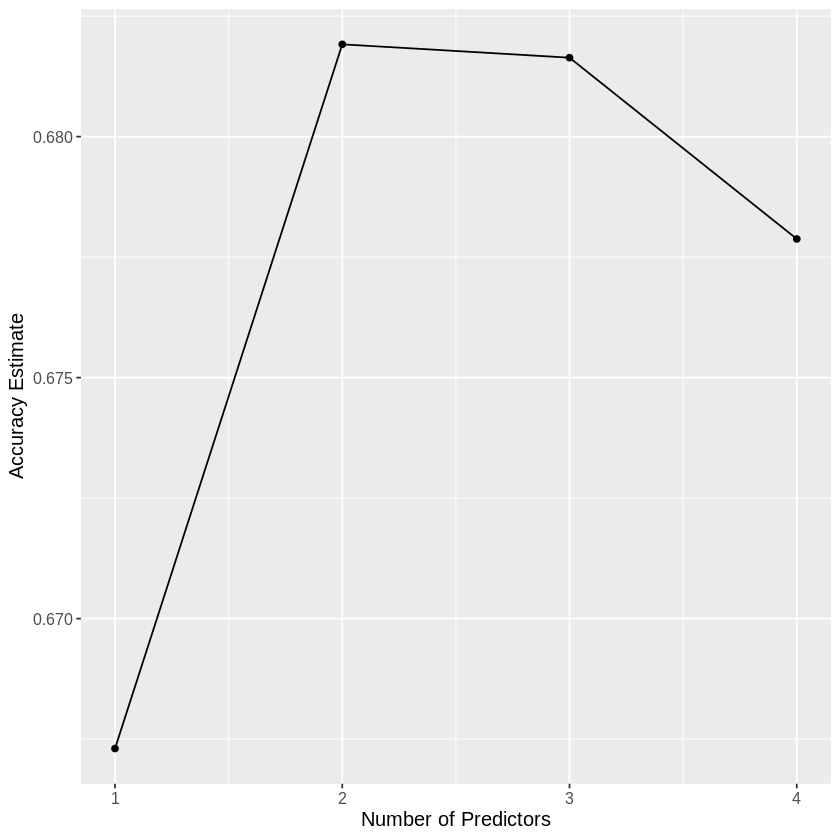

In [60]:
accuracy_vs_k <- ggplot(accuracies, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Predictors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

Notice that the number of predictors is estimated to be the most accurate at two predictors.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



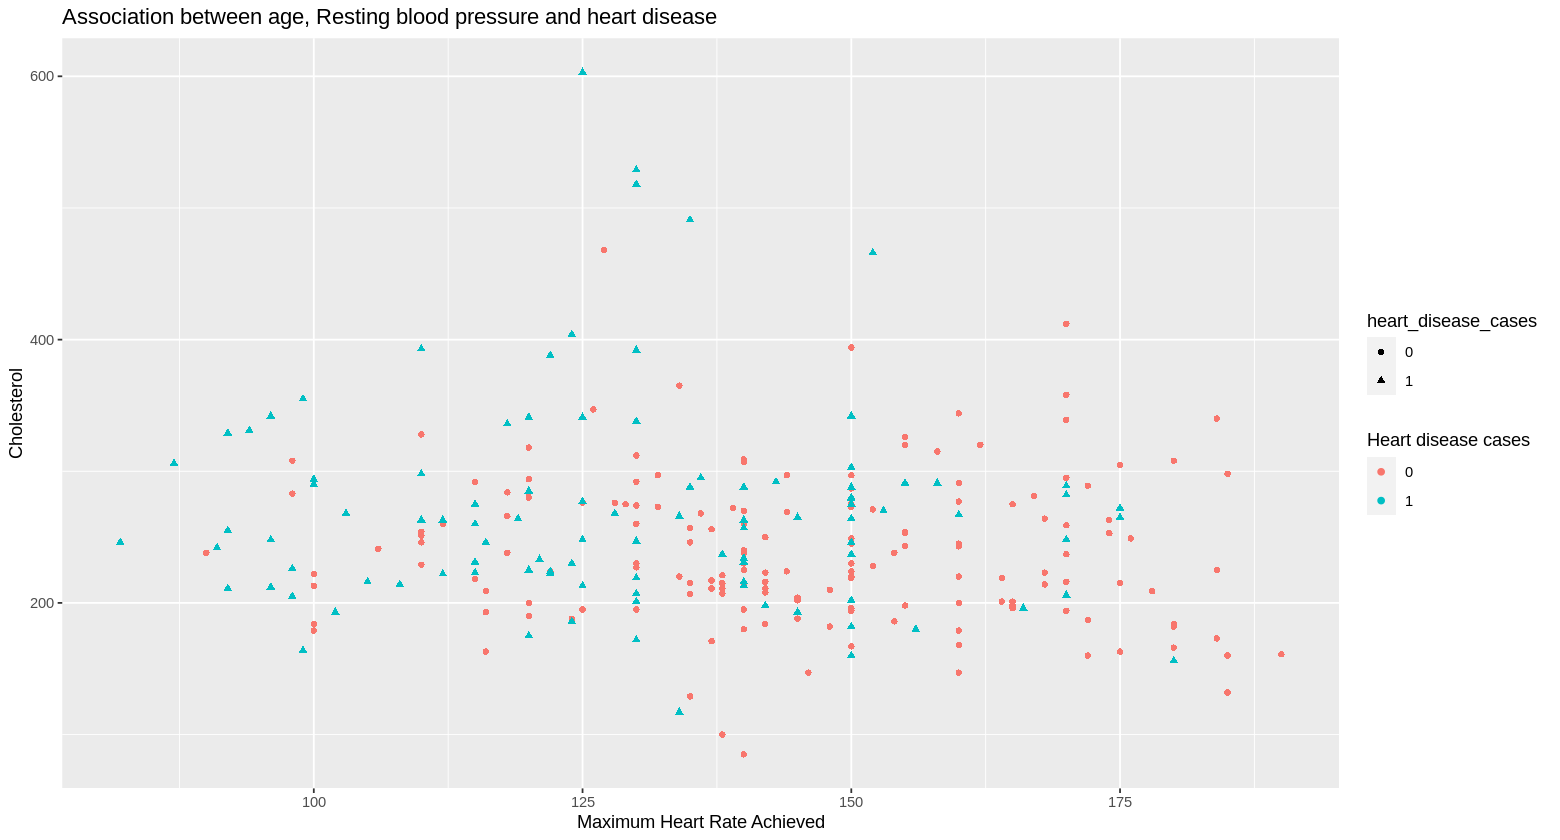

In [68]:
options(repr.plot.width = 13, repr.plot.height = 7)


heart_disease_plot_best <- heart_disease_hungarian |> 
    ggplot(aes(x = maximum_heart_rate_achieved, y = cholesterol, color = heart_disease_cases, shape = heart_disease_cases)) + 
        geom_point() +
        labs(x = "Maximum Heart Rate Achieved", y = "Cholesterol", color = "Heart disease cases", title = "Association between Maximum Heart Rate Achieved, and Heart Disease")

heart_disease_plot <- heart_disease_plot + 
       scale_fill_brewer(palette = "YlOrRd")
heart_disease_plot_best

### Discussion:
#### What did we find?
#### Is this what we expected?
#### What impacts do these findings have?
#### What future questions does this lead to?

#### What do we expect to find: 
We expect to find associations between heart disease with our chosen predictors. Based on our findings we will be able to identify the most telltale variable for heart disease as well as the relationship predictors may have with one another. We can expect heart disease risk and diagnosis to increase with age, but the same could not be said for the other predictors.

#### What impact do such findings have:
Our findings will contribute to identifying portions of the population at higher risk for heart disease based on our predictor variables. This research is done to advocate for health and prevention and to contribute to the current knowledge we have on heart disease.

#### What future questions could this lead to: 
Our project leads to many future questions: How can we prevent it within the population, especially if the community doesn't necessarily have the resources for prevention? Also, what other variables other than the ones we have tested could lead to being predisposed to heart disease? Lastly, how much control do patients have over their risk for heart disease and how can they prevent heart disease with this new information?

### References:
- Ashley, E. A., Raxwal, V., & Froelicher, V. (2001). An evidence-based review of the resting electrocardiogram as a screening technique for heart disease. Progress in Cardiovascular Diseases, 44(1), 55–67. https://doi.org/10.1053/pcad.2001.24683
- He, K., Chen, X., Shi, Z., Shi, S., Tian, Q., Hu, X., Song, R., Bai, K., Shi, W., Wang, J., Li, H., Ding, J., Geng, S., & Sheng, X. (2022). Relationship of resting heart rate and blood pressure with all-cause and cardiovascular disease mortality. Public Health, 208, 80–88. https://doi.org/10.1016/j.puhe.2022.03.020 
- Maas, A. H. E. M., & Appelman, Y. E. A. (2010). Gender differences in coronary heart disease. Netherlands Heart Journal, 18(12), 598–603. https://doi.org/10.1007/s12471-010-0841-y
- Moran, A. E., Tzong, K. Y., Forouzanfar, M. H., Roth, G. A., Mensah, G. A., Ezzati, M., Murray, C. J. L., & Naghavi, M. (2014). Variations in ischemic heart disease burden by age, country, and income: the global burden of diseases, injuries, and risk factors 2010 study. Global Heart, 9(1), 91. https://doi.org/10.1016/j.gheart.2013.12.007 
- Park, C., Guallar, E., Linton, J. A., Lee, D.-C., Jang, Y., Son, D. K., Han, E.-J., Baek, S. J., Yun, Y. D., Jee, S. H., & Samet, J. M. (2013). Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), 1988–1993. https://doi.org/10.2337/dc12-1577 